## Runing the AANET on the MNIST dataset


In [338]:
import sys, torch, scprep
sys.path.append('../')
import warnings; warnings.filterwarnings('ignore')
from AAnet_torch import *
from torch import optim
import torchvision; from torchvision import datasets, transforms
import numpy as np
import matplotlib; import matplotlib.pyplot as plt
from AAnet_torch import models, utils, data, plot
import os
from scipy.spatial.distance import squareform, pdist
import umap

## Load MNIST data

In [339]:
# 1. Load and Preprocess MNIST (The "Binary" way)
print("Loading MNIST...")
transform = transforms.Compose([transforms.ToTensor(), transforms.ToTensor()])
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_all = mnist.data.numpy()
data_all = data_all / 255
data_all = (data_all * 2) - 1 # norm
labels = mnist.targets.numpy()

print("MNIST Loaded. Data shape:", data_all.shape)

Loading MNIST...
MNIST Loaded. Data shape: (60000, 28, 28)


In [340]:

# Pick single digit
digit = 4

# Select data for the specified digit
idx_digit = mnist.targets.numpy() == digit

# Create dataset for the selected digit
data_digit = data_all[idx_digit,]

# Reshape data to 2D array (samples x features)
data_digit = np.reshape(data_digit, (data_digit.shape[0], -1))

# Print shape of the digit-specific dataset
print(data_digit.shape)



(5842, 784)


## AAnet

In [341]:
N_ARCHETYPES = 3
N_RUNS = 3
N_EPOCHS = 10 
N_PROTOTYPES = 10     

#SAVE_DIR = 'results/MNIST_AANET_1run50epochs'
#SAVE_DIR = 'results/MNIST_5runs'
SAVE_DIR = 'results/MNIST_10epochs'

os.makedirs(SAVE_DIR, exist_ok=True)

data_loader = torch.utils.data.DataLoader(data_digit, batch_size=256, shuffle=True, num_workers=4)

# Added a transposoition to ensure final shape
X = torch.tensor(data_digit, dtype=torch.float64).transpose(0, 1)

# Warm-start model with graph-based extrema for improved results
extrema = torch.Tensor(utils.get_laplacian_extrema(data_digit, n_extrema=N_ARCHETYPES))
extrema = torch.Tensor(data_digit[extrema.numpy().astype(int)])



In [342]:
device = torch.device('cpu')

### Run AAnet

In [ ]:
from tqdm import trange
import torch
import numpy as np
import os

S_list = []
C_list = []
loss_history = []  # Track loss per run
metrics_history = []  # Track metrics at checkpoints

# Define checkpoints to evaluate
CHECKPOINTS = [1, 3, 5, 7, 10]  # Epochs to compute metrics

# Storage for checkpoint results
checkpoint_results = {ep: {'S_list': [], 'C_list': []} for ep in CHECKPOINTS}

for run in range(N_RUNS):
    print(f"\n{'='*50}")
    print(f"Run {run+1}/{N_RUNS}")
    print(f"{'='*50}")
    
    # Reset model for each run (important!)
    model = models.AAnet_vanilla(noise=0.05, layer_widths=[256, 128],
                                  n_archetypes=N_ARCHETYPES, 
                                  input_shape=data_digit.shape[1],
                                  device=device, diffusion_extrema=None)
    
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    run_losses = []
    
    # Train for N_EPOCHS with progress bar
    for epoch in trange(1, N_EPOCHS + 1, desc=f"Training Run {run+1}", leave=True):
        loss, r_loss, a_loss = utils.train_epoch(model, data_loader, optimizer, 
                                                   epoch=epoch, gamma_extrema=1.0)
        run_losses.append(loss)
        
        # Print loss every few epochs
        if epoch % 2 == 0 or epoch == 1:
            print(f"  Epoch {epoch:2d} | Loss: {loss:.6f} | R_loss: {r_loss:.6f} | A_loss: {a_loss:.6f}")
        
        # Save embeddings at checkpoints
        if epoch in CHECKPOINTS:
            archetypal_embedding = model.encode(torch.Tensor(data_digit)).detach().numpy()
            barycentric_embedding = model.euclidean_to_barycentric(
                torch.Tensor(archetypal_embedding)).detach().numpy()
            
            S_T = barycentric_embedding.T
            C = S_T.T
            
            checkpoint_results[epoch]['S_list'].append(S_T)
            checkpoint_results[epoch]['C_list'].append(C)
    
    # Store loss history
    loss_history.append(run_losses)
    
    # Encode final embeddings (epoch 10)
    archetypal_embedding = model.encode(torch.Tensor(data_digit)).detach().numpy()
    barycentric_embedding = model.euclidean_to_barycentric(
        torch.Tensor(archetypal_embedding)).detach().numpy()
    
    S_T = barycentric_embedding.T
    C = S_T.T
    
    # Save final run results
    S_list.append(S_T)
    C_list.append(C)
    
    print(f"\n✓ Run {run+1} complete - S shape: {S_T.shape}, C shape: {C.shape}")
    
    # Optional: save per run
    np.savez(os.path.join(SAVE_DIR, f'run{run+1}_results.npz'), 
             S=S_T, C=C, X=data_digit, losses=run_losses)

# Save all runs together
torch.save({
    'S_list': S_list, 
    'C_list': C_list, 
    'X': data_digit,
    'loss_history': loss_history,
    'checkpoint_results': checkpoint_results
}, os.path.join(SAVE_DIR, 'mnist_aanet_aa_results.pth'))

# Save the model state dict of the last run
torch.save(model.state_dict(), os.path.join(SAVE_DIR, 'mnist_aanet_model_last_run.pth'))

print(f"\n{'='*50}")
print(f"✅ Saved all {N_RUNS} runs results.")
print(f"{'='*50}")

### Visualize the training


📊 Plotting training curves...


ValueError: x and y must have same first dimension, but have shapes (10,) and (50,)

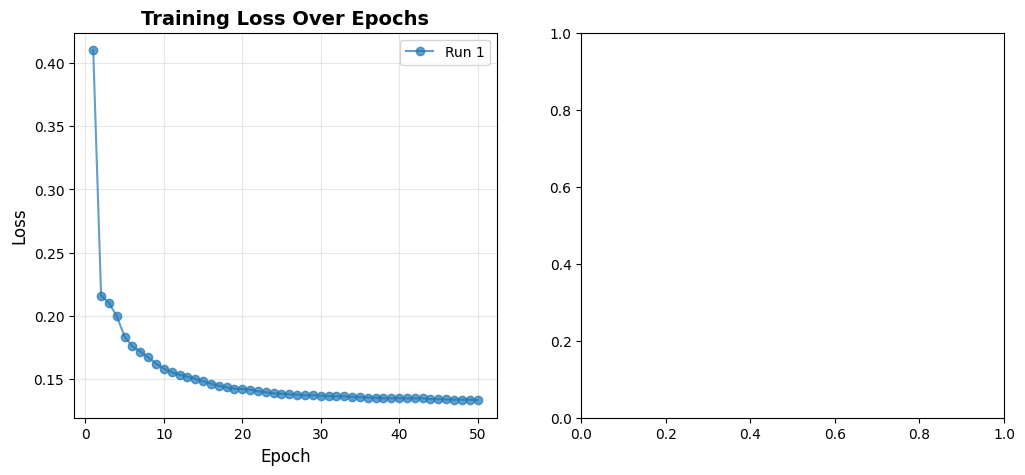

In [344]:

# =========================================
# VISUALIZE TRAINING PROGRESS
# =========================================

print("\n📊 Plotting training curves...")

# 1. Plot Loss Curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for i, losses in enumerate(loss_history):
    plt.plot(range(1, len(losses) + 1), losses, marker='o', label=f'Run {i+1}', alpha=0.7)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Plot Average Loss ± Std
plt.subplot(1, 2, 2)
loss_array = np.array(loss_history)
mean_loss = loss_array.mean(axis=0)
std_loss = loss_array.std(axis=0)
epochs = np.arange(1, N_EPOCHS + 1)

plt.plot(epochs, mean_loss, marker='o', linewidth=2, color='blue', label='Mean Loss')
plt.fill_between(epochs, mean_loss - std_loss, mean_loss + std_loss, 
                 alpha=0.3, color='blue', label='±1 Std')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Mean Training Loss Across Runs', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, 'training_loss_curves.png'), dpi=150, bbox_inches='tight')
plt.show()

# Print the final loss
print(f"Final Loss after {N_EPOCHS} epochs:")
for i, losses in enumerate(loss_history):
    print(f"  Run {i+1}: {losses[-1]:.6f}")


## Visualize the Results

In [244]:
# Open the saved results to verify

results = torch.load('/Users/joaomata/Desktop/DTU/DeepLearning/ProjectDL/AAnet/example_notebooks/results/MNIST_10epochs/mnist_aanet_aa_results.pth', weights_only=False)
#results = torch.load("/Users/joaomata/Desktop/DTU/DeepLearning/ProjectDL/AAnet/example_notebooks/results/MNIST_AANET_71runs/mnist_aanet_aa_results.pth", weights_only=False)
#results = torch.load('/Users/joaomata/Desktop/DTU/DeepLearning/ProjectDL/AAnet/example_notebooks/results/MNIST_AANET_1run50epochs/mnist_aanet_aa_results.pth', weights_only=False)

# load from the new SAVE_DIR
print("Saved Results Keys:", results.keys())
print("Number of Runs Saved:", len(results['C_list']))

# Print shapes if the first run to verify
print("Shape of C in first run:", results['C_list'][0].shape)
print("Shape of S in first run:", results['S_list'][0].shape)
print('Shape of X in first run:', results['X'].shape)

Saved Results Keys: dict_keys(['S_list', 'C_list', 'X', 'loss_history', 'checkpoint_results'])
Number of Runs Saved: 3
Shape of C in first run: (5842, 3)
Shape of S in first run: (3, 5842)
Shape of X in first run: (5842, 784)


# Metric Formulas

In [345]:
def to_numpy(tensor):
    if isinstance(tensor, torch.Tensor):
        return tensor.detach().cpu().numpy()
    return tensor

def preprocess(X):
    meanX = np.mean(X, axis=0)
    X_centered = X - meanX
    mSST = np.sum(np.mean(X_centered**2, axis=0))
    return X_centered, mSST

def calcMI(z1, z2):
    eps = 10e-16
    P = z1 @ z2.T
    PXY = P / P.sum()
    PXPY = np.outer(np.expand_dims(PXY.sum(1), axis=0), np.expand_dims(PXY.sum(0), axis=1))
    ind = np.nonzero(PXY > 0)
    MI = np.sum(PXY * np.log(eps + PXY / (eps + PXPY)))
    return MI

def calcNMI(z1, z2):
    NMI = (2 * calcMI(z1, z2)) / (calcMI(z1, z1) + calcMI(z2, z2))
    return NMI

def ArchetypeConsistency(XC1, XC2, mSST):
    D = squareform(pdist(np.hstack((XC1, XC2)).T, 'euclidean'))**2
    D = D[:XC1.shape[1], XC1.shape[1]:]
    # Greedy matching
    i = []
    j = []
    v = []
    K = XC1.shape[1]
    for k in range(K):
        min_index = np.unravel_index(np.argmin(D, axis=None), D.shape)
        i.append(min_index[0])
        j.append(min_index[1])
        v.append(D[i[-1], j[-1]])
        D[i[-1], :] = np.inf
        D[:, j[-1]] = np.inf
    consistency = 1 - np.mean(v) / mSST
    D2 = np.abs(np.corrcoef(np.hstack((XC1, XC2)).T))
    D2 = D2[:K, K:]
    ISI = 1 / (2 * K * (K - 1)) * (np.sum(D2 / np.max(D2, axis=1, keepdims=True) + D2 / np.max(D2, axis=0, keepdims=True)) - 2 * K)
    return consistency, ISI

In [346]:
from itertools import combinations

# Calculate metrics over the runs
C_matrices = [to_numpy(C) for C in results['C_list']]
print("C_matrices length:", len(C_matrices))
print("C_matrices[0] shape:", C_matrices[0].shape)
S_matrices = [to_numpy(S) for S in results['S_list']]
print("S_matrices length:", len(S_matrices))
print("S_matrices[0] shape:", S_matrices[0].shape)

X_centered, mSST = preprocess(to_numpy(X))

X_raw = to_numpy(X)

def compute_stability_metrics(S_list, C_list, X_raw, N_RUNS):
    """
    Compute pairwise stability metrics across runs.
    
    Returns:
        nmi_matrix, consistency_matrix, isi_matrix
    """
    X_centered, mSST_val = preprocess(X_raw)

    nmi_matrix = np.zeros((N_RUNS, N_RUNS))
    consistency_matrix = np.zeros((N_RUNS, N_RUNS))
    isi_matrix = np.zeros((N_RUNS, N_RUNS))

    for i, j in combinations(range(N_RUNS), 2):
        S_i, S_j = S_list[i], S_list[j]
        C_i, C_j = C_list[i], C_list[j]

        nmi_matrix[i, j] = calcNMI(S_i, S_j)
        consistency_matrix[i, j], isi_matrix[i, j] = ArchetypeConsistency(C_i, C_j, mSST_val)

    # Fill symmetric and diagonal
    nmi_matrix += nmi_matrix.T
    consistency_matrix += consistency_matrix.T
    isi_matrix += isi_matrix.T
    np.fill_diagonal(nmi_matrix, 1)
    np.fill_diagonal(consistency_matrix, 1)
    np.fill_diagonal(isi_matrix, 1)

    return nmi_matrix, consistency_matrix, isi_matrix

# --- Compute for Linear AA ---
nmi_linear, consistency_linear, isi_linear = compute_stability_metrics(S_matrices, C_matrices, X_raw, N_RUNS)

print("---")
print("Deep AANET AA 3-run stability:")
print("---")
print("Mean NMI:", np.mean(nmi_linear[np.triu_indices(N_RUNS, 1)]))
print("Mean Archetype Consistency:", np.mean(consistency_linear[np.triu_indices(N_RUNS, 1)]))
print("Mean ISI:", np.mean(isi_linear[np.triu_indices(N_RUNS, 1)]))


C_matrices length: 3
C_matrices[0] shape: (5842, 3)
S_matrices length: 3
S_matrices[0] shape: (3, 5842)
---
Deep AANET AA 3-run stability:
---
Mean NMI: 0.8370934184284081
Mean Archetype Consistency: 0.8325935158003405
Mean ISI: 0.5334680895856398


---

# Archetypal Analysis

In [247]:
# Select archetypes to visualize from the loaded results
C_aanet = results['C_list'][0]
S_aanet = results['S_list'][0]

print("C_aanet shape:", C_aanet.shape)
print("S_aanet shape:", S_aanet.shape)

C_aanet shape: (5842, 3)
S_aanet shape: (3, 5842)


### Visualizing the Archetypes

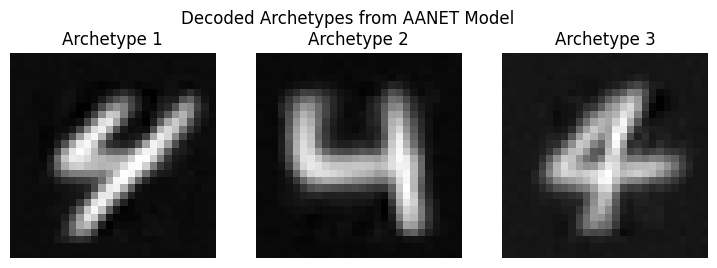

In [314]:
def plot_decoded_archetypes(model, img_shape=(28, 28), title="Decoded Archetypes"):
    """
    Decode and visualize archetypes from a trained AANET model.

    Parameters
    ----------
    model : AAnet_vanilla
        Trained AANET model.
    img_shape : tuple, default=(28,28)
        Shape to reshape the decoded archetypes.
    title : str
        Title for the plot.
    """
    model.eval()  # set to evaluation mode

    # 1. Get latent-space coordinates of archetypes
    if hasattr(model, 'archetypal_simplex'):
        z_archetypes = model.archetypal_simplex  # shape: [K, latent_dim]
    else:
        raise ValueError("Model has no attribute 'archetypal_simplex'.")

    # 2. Decode to pixel space
    with torch.no_grad():
        decoded_archetypes = model.decode(z_archetypes)  # shape: [K, D]

    # 3. Convert to numpy and transpose for plotting (D × K)
    C_recon = decoded_archetypes.cpu().numpy().T  # shape: (D, K)
    K = C_recon.shape[1]

    # 4. Plot
    fig, axes = plt.subplots(1, K, figsize=(3*K, 3))
    for i in range(K):
        axes[i].imshow(C_recon[:, i].reshape(img_shape), cmap="gray")
        axes[i].set_title(f"Archetype {i+1}")
        axes[i].axis("off")

    plt.suptitle(title)
    plt.show()

plot_decoded_archetypes(model, img_shape=(28, 28), title="Decoded Archetypes from AANET Model")

In [315]:
# Make sure your model is in eval mode
model.eval()

# Get latent simplex corners for n_archetypes
z_archetypes = model.get_n_simplex(n=N_ARCHETYPES).to(model.device)

# Decode them through the non-linear decoder
with torch.no_grad():
    C_decoded = model.decode(z_archetypes)  # shape: (n_archetypes, D)

C_decoded = C_decoded.cpu().numpy()  # convert to numpy for plotting


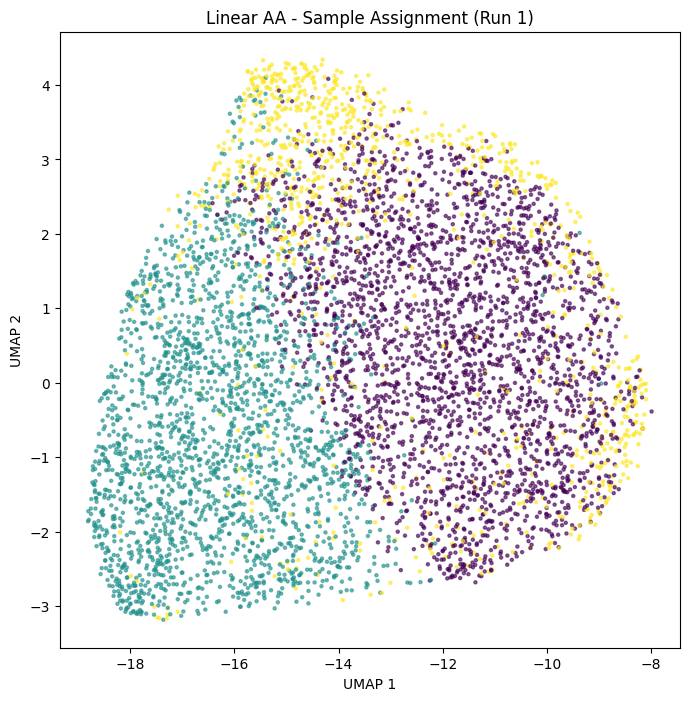

In [347]:

def plot_umap_assignment(X, S, title="Sample Assignment", s=5, alpha=0.6, cmap='viridis'):

    # Convert S to numpy if tensor
    S = to_numpy(S)
    X = to_numpy(X)

    # Step 1: compute dominant archetype for each sample
    dominant_arc = np.argmax(S, axis=0)  # shape: (N_samples,)

    # Step 2: reduce X to 2D using UMAP
    reducer = umap.UMAP(n_neighbors=30, min_dist=0.3, random_state=42)
    X_embedded = reducer.fit_transform(X)  # shape: (N_samples, 2)

    # Step 3: scatter plot colored by dominant archetype
    n_archetypes = S.shape[0]
    plt.figure(figsize=(8,8))
    scatter = plt.scatter(
        X_embedded[:,0],
        X_embedded[:,1],
        c=dominant_arc,
        cmap=cmap,
        s=s,
        alpha=alpha
    )
    plt.title(title)
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.show()

# Linear AA: S_matrices[0] shape (k × N_samples)
plot_umap_assignment(X_samples, S_matrices[0], title="Linear AA - Sample Assignment (Run 1)")


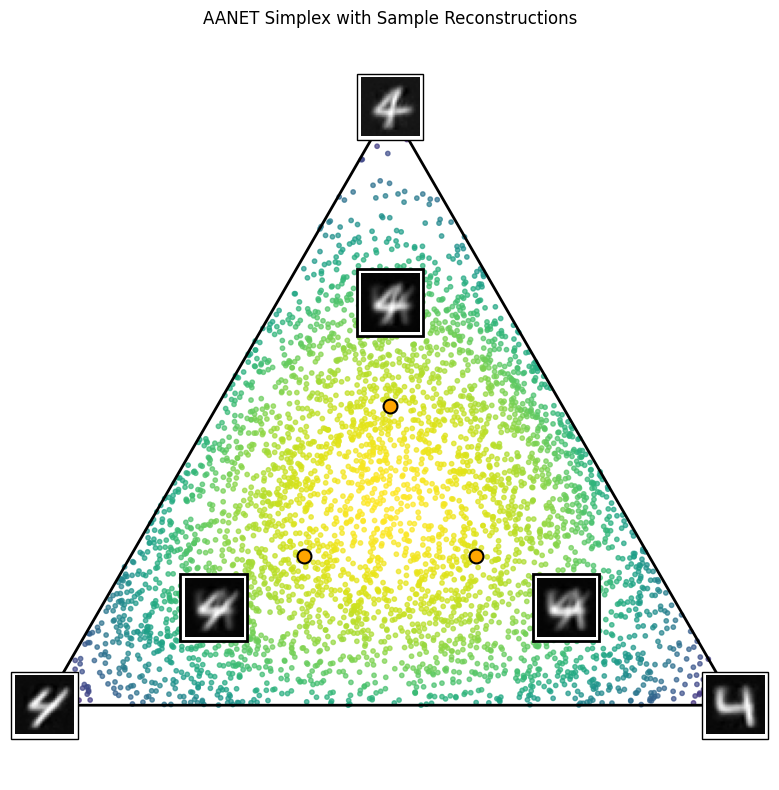

In [317]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.stats import entropy

def plot_simplex_with_samples(S, C=None, title="Simplex Plot", s=10, cmap='viridis', 
                               show_archetypes=True, sample_points=None, img_shape=(28, 28),
                               zoom=1.5):
    """
    Plot simplex with sample reconstructions at specific barycentric coordinates.
    
    Parameters:
    -----------
    S : array, shape (k, N)
        Simplex coordinates (archetype weights) for N samples
    C : array, shape (d, k) or (k, d)
        Archetype matrix - will be auto-detected and transposed if needed
    sample_points : list of tuples, optional
        List of barycentric coordinates (w1, w2, w3) where sum=1
        E.g., [(0.5, 0.3, 0.2), (0.33, 0.33, 0.34)]
    img_shape : tuple
        Shape to reshape features for display (height, width)
    zoom : float
        Zoom level for displayed images
    """
    S = np.array(S)
    k, N = S.shape
    if k != 3:
        raise ValueError("Simplex plot only works for k=3 archetypes")
    
    # Auto-detect and fix C orientation
    if C is not None:
        C = np.array(C)
        if C.shape[0] == 3 and C.shape[1] != 3:
            # C is (3, d), need (d, 3)
            C = C.T
        elif C.shape[0] != np.prod(img_shape):
            print(f"Warning: C shape {C.shape} may not match img_shape {img_shape}")
    
    # Barycentric coordinates -> 2D triangle coordinates
    vertices = np.array([[0, 0], [1, 0], [0.5, np.sqrt(3)/2]])
    X_simplex = S.T @ vertices  # shape: (N, 2)
    
    # Compute mixing strength (entropy)
    mix_strength = np.array([entropy(S[:, i]) for i in range(N)])
    mix_strength /= np.log(3)  # normalize between 0 and 1
    
    # Create plot
    plt.figure(figsize=(8, 8))
    
    # Plot all samples
    plt.scatter(X_simplex[:, 0], X_simplex[:, 1], c=mix_strength, 
                cmap=cmap, s=s, alpha=0.7)
    
    # Draw triangle edges
    triangle = Polygon(vertices, fill=False, linewidth=2)
    plt.gca().add_patch(triangle)
    
    # Plot archetypes at corners
    if show_archetypes and C is not None:
        for i in range(3):
            img = C[:, i].reshape(img_shape)
            im_box = OffsetImage(img, zoom=zoom, cmap='gray')
            ab = AnnotationBbox(im_box, vertices[i], frameon=True, pad=0.3)
            plt.gca().add_artist(ab)
    
    # Plot sample reconstructions at specified points
    if sample_points is not None and C is not None:
        for weights in sample_points:
            weights = np.array(weights)
            # Ensure weights sum to 1
            weights = weights / weights.sum()
            
            # Compute 2D position in triangle
            pos_2d = weights @ vertices
            
            # Reconstruct image: X_reconstructed = C @ weights
            reconstructed = C @ weights
            img = reconstructed.reshape(img_shape)
            
            # Mark the point
            plt.scatter(pos_2d[0], pos_2d[1], c='orange', s=100, 
                       marker='o', edgecolors='black', linewidths=1.5, zorder=10)
            
            # Display reconstructed image near the point
            im_box = OffsetImage(img, zoom=zoom, cmap='gray')
            # Offset the image slightly outward from center for better visibility
            offset = pos_2d - np.array([0.5, np.sqrt(3)/6])
            offset = offset / np.linalg.norm(offset) * 0.15
            ab = AnnotationBbox(im_box, pos_2d + offset, frameon=True, 
                               pad=0.3, bboxprops=dict(linewidth=2))
            plt.gca().add_artist(ab)
    
    plt.title(title)
    plt.axis('equal')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


# Example usage:
# Select points in barycentric coordinates (must sum to 1)
# Place sample points equally distanced to each corner of the simplex
sample_points = [
    (0.1, 0.05, 0.05),  # Near archetype 0
    (0.05, 0.1, 0.05),  # Near archetype 1
    (0.05, 0.05, 0.1)   # Near archetype 2
]

plot_simplex_with_samples(S_list[0], C=C_decoded.T, 
                          title="AANET Simplex with Sample Reconstructions",
                          sample_points=sample_points)

### Calculating the MSE of the reconstructions

In [ ]:


def normalize_S(S, N):
    """Ensure S has shape (K, N)."""
    S = to_numpy(S)
    if S.shape[1] == N:
        return S             # already (K, N)
    if S.shape[0] == N:
        return S.T           # was (N, K)
    raise ValueError(f"Cannot reshape S. Got {S.shape}, expected (K,N) or (N,K).")

def compute_C_from_S(X_raw, S):
    """C = X Sᵀ (S Sᵀ)^(-1). Produces (D, K)."""
    SST = S @ S.T
    return X_raw @ S.T @ np.linalg.pinv(SST)

def reconstruct(X_raw, C_saved, S_saved):
    """
    Reconstruct X using saved S and (maybe) saved C.
    Returns X_rec (N,D), C_features (D,K), S_kxn (K,N).
    """
    X_raw = to_numpy(X_raw)        # (D, N)
    D, N = X_raw.shape

    S = normalize_S(S_saved, N)    # (K, N)
    K = S.shape[0]

    C_saved = to_numpy(C_saved)

    # If C is not (D,K), recompute from X and S
    if C_saved.shape != (D, K):
        C_feat = compute_C_from_S(X_raw, S)
    else:
        C_feat = C_saved

    # Reconstruction: (D,K)(K,N) = (D,N) → transpose → (N,D)
    X_rec = (C_feat @ S).T
    return X_rec, C_feat, S

def mse_metrics(X_true, X_rec):
    X_true = np.asarray(X_true)
    X_rec  = np.asarray(X_rec)

    N, D = X_true.shape
    residuals = X_true - X_rec

    SSE = np.sum(residuals**2)
    MSE = SSE / (N * D)
    RMSE = np.sqrt(MSE)

    mean_x = X_true.mean(axis=0)
    SST = np.sum((X_true - mean_x)**2)
    R2 = 1 - SSE/SST if SST > 0 else np.nan

    return dict(MSE=MSE, RMSE=RMSE, R2=R2)



In [330]:
with torch.no_grad():
    X_tensor = torch.tensor(X_samples, dtype=torch.float32).to(device)   # N × 784
    Z = model.encode(X_tensor)                                           # N × latent_dim
    X_rec_AANET = model.decode(Z).cpu().numpy()                           # N × 784

# Evaluate reconstruction metrics
metrics_aanet = mse_metrics(X_samples, X_rec_AANET)
print("AANET Reconstruction Metrics:", metrics_aanet)


AANET Reconstruction Metrics: {'MSE': 0.1255284231868203, 'RMSE': 0.3542999057109955, 'R2': 0.3980383730402388}


### Analysing each checkpoint in the training

In [348]:
results.keys()
# print checkpoint results keys
checkpoint_results = results['checkpoint_results']
print("Checkpoint Results Keys:", checkpoint_results.keys())
# print the inside of each checkpoint
for ep in checkpoint_results:
    print(f" Epoch {ep} Keys:", checkpoint_results[ep].keys())
    

Checkpoint Results Keys: dict_keys([1, 3, 5, 7, 10])
 Epoch 1 Keys: dict_keys(['S_list', 'C_list'])
 Epoch 3 Keys: dict_keys(['S_list', 'C_list'])
 Epoch 5 Keys: dict_keys(['S_list', 'C_list'])
 Epoch 7 Keys: dict_keys(['S_list', 'C_list'])
 Epoch 10 Keys: dict_keys(['S_list', 'C_list'])



📈 Computing metrics at checkpoints (per run)...

📊 Plotting metrics evolution (per run)...


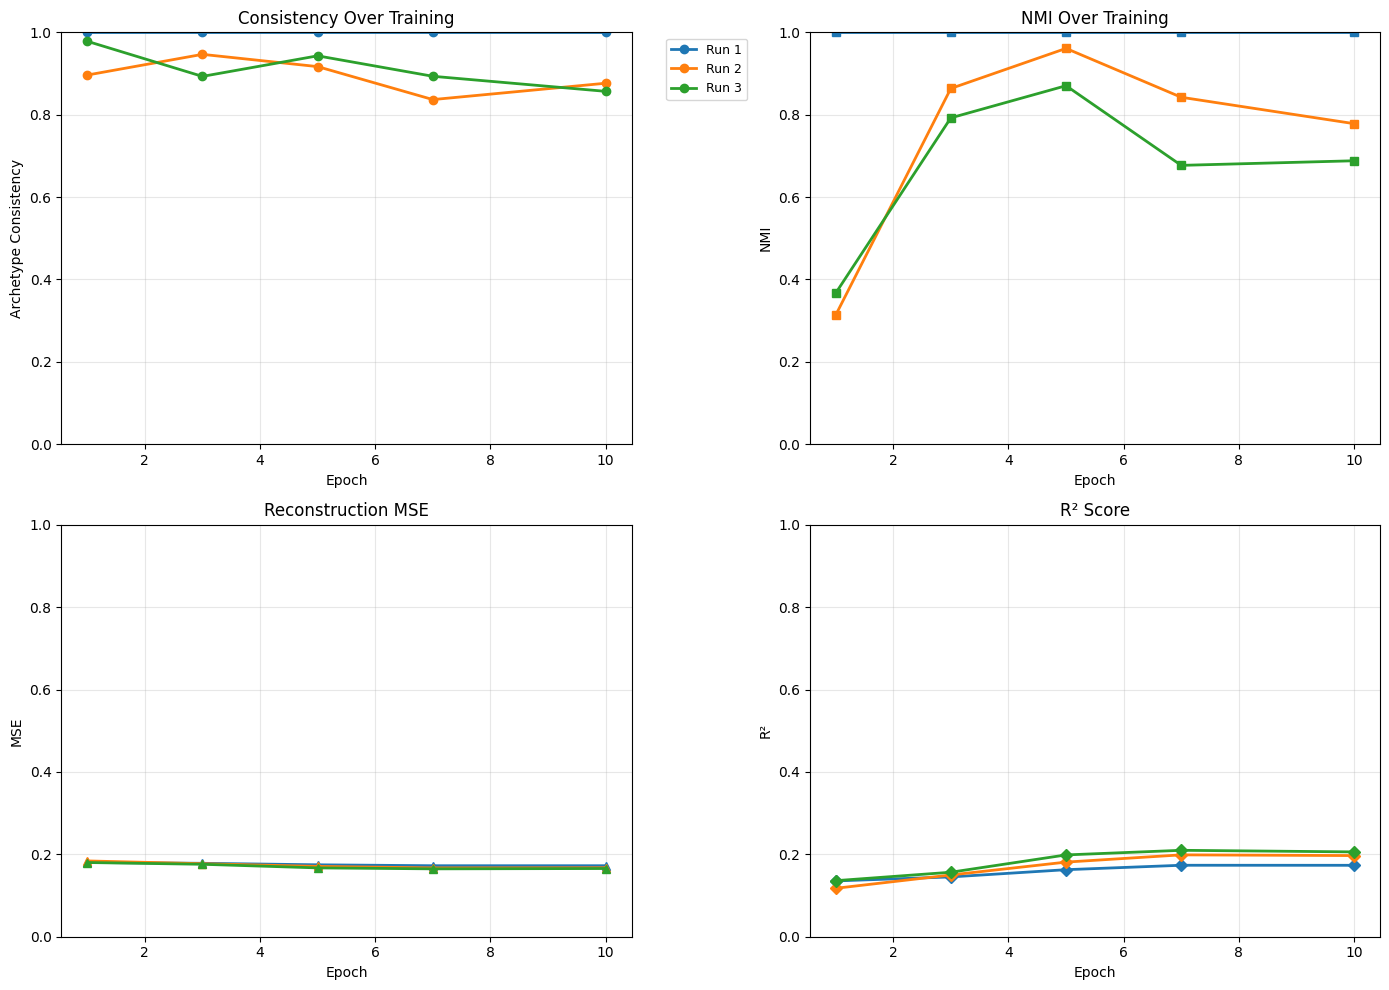

In [349]:
# =========================================
# COMPUTE METRICS AT EACH CHECKPOINT (PER RUN)
# =========================================

print("\n📈 Computing metrics at checkpoints (per run)...")

# Initialize per-run metrics
checkpoint_metrics_per_run = {
    run: {'epoch': [], 'consistency': [], 'nmi': [], 'isi': [], 'mse': [], 'r2': []}
    for run in range(N_RUNS)
}

X_samples = X_raw.T  # shape: (N_samples, features)

for epoch in checkpoint_results.keys():
    S_list_cp = checkpoint_results[epoch]['S_list']
    C_list_cp = checkpoint_results[epoch]['C_list']
    
    for run_idx in range(N_RUNS):
        # Compare each run to first run (or any reference run)
        S_i, C_i = S_list_cp[run_idx], C_list_cp[run_idx]
        S_ref, C_ref = S_list_cp[0], C_list_cp[0]
        
        # Stability metrics
        nmi_val = calcNMI(S_i, S_ref)
        consistency_val, isi_val = ArchetypeConsistency(C_i, C_ref, mSST)
        
        # Reconstruction metrics
        X_rec_cp, _, _ = reconstruct(X_samples.T, C_i, S_i)
        metrics_cp = mse_metrics(X_samples, X_rec_cp)
        
        # Store per-run metrics
        checkpoint_metrics_per_run[run_idx]['epoch'].append(epoch)
        checkpoint_metrics_per_run[run_idx]['consistency'].append(consistency_val)
        checkpoint_metrics_per_run[run_idx]['nmi'].append(nmi_val)
        checkpoint_metrics_per_run[run_idx]['isi'].append(isi_val)
        checkpoint_metrics_per_run[run_idx]['mse'].append(metrics_cp['MSE'])
        checkpoint_metrics_per_run[run_idx]['r2'].append(metrics_cp['R2'])

# =========================================
# PLOT METRICS OVER EPOCHS (ONE LINE PER RUN)
# =========================================

print("\n📊 Plotting metrics evolution (per run)...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

colors = plt.cm.tab10.colors  # up to 10 runs, repeat if more

for run_idx in range(N_RUNS):
    metrics = checkpoint_metrics_per_run[run_idx]
    color = colors[run_idx % len(colors)]
    
    axes[0, 0].plot(metrics['epoch'], metrics['consistency'], marker='o', linewidth=2, markersize=6, color=color, label=f'Run {run_idx+1}')
    axes[0, 1].plot(metrics['epoch'], metrics['nmi'], marker='s', linewidth=2, markersize=6, color=color, label=f'Run {run_idx+1}')
    axes[1, 0].plot(metrics['epoch'], metrics['mse'], marker='^', linewidth=2, markersize=6, color=color, label=f'Run {run_idx+1}')
    axes[1, 1].plot(metrics['epoch'], metrics['r2'], marker='D', linewidth=2, markersize=6, color=color, label=f'Run {run_idx+1}')

# Labels, titles, grid
axes[0, 0].set_xlabel('Epoch'); axes[0, 0].set_ylabel('Archetype Consistency'); axes[0, 0].set_title('Consistency Over Training'); axes[0, 0].grid(True, alpha=0.3); axes[0, 0].set_ylim([0,1.0])
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('NMI')
axes[0, 1].set_title('NMI Over Training')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim([0, 1.0])

axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('MSE')
axes[1, 0].set_title('Reconstruction MSE')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim([0, 1.0])

axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('R²')
axes[1, 1].set_title('R² Score')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim([0, 1.0])

# Optional: legend
axes[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[0,1].legend().remove()
axes[1,0].legend().remove()
axes[1,1].legend().remove()

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, 'metrics_evolution_per_run.png'), dpi=150, bbox_inches='tight')
plt.show()


In [350]:
# =========================================
# SUMMARY TABLE
# =========================================

print("\n" + "="*70)
print("SUMMARY: Metrics Across Training Epochs")
print("="*70)
print(f"{'Epoch':<8} {'Consistency':<15} {'NMI':<12} {'MSE':<12} {'R²':<10}")
print("-"*70)
for i, ep in enumerate(checkpoint_metrics['epoch']):
    print(f"{ep:<8} {checkpoint_metrics['consistency'][i]:<15.6f} "
          f"{checkpoint_metrics['nmi'][i]:<12.6f} "
          f"{checkpoint_metrics['mse'][i]:<12.6f} "
          f"{checkpoint_metrics['r2'][i]:<10.6f}")
print("="*70)


SUMMARY: Metrics Across Training Epochs
Epoch    Consistency     NMI          MSE          R²        
----------------------------------------------------------------------
1        0.919847        0.341450     0.180283     0.135466  
3        0.931642        0.849680     0.178259     0.145175  
5        0.911434        0.916528     0.174595     0.162745  
7        0.843393        0.840981     0.172353     0.173496  
10       0.832594        0.837093     0.172371     0.173409  


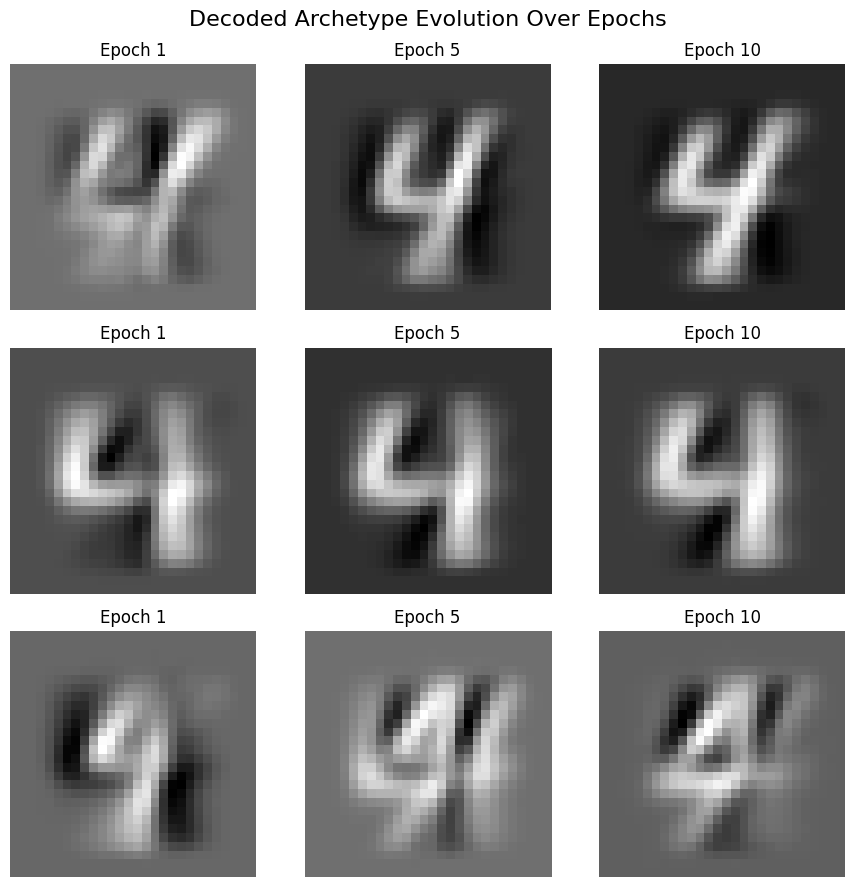

In [351]:
# Plot the evolution of all 3 archetypes over training epochs (decoded AA)
img_shape = (28, 28)
n_archetypes = N_ARCHETYPES

# Only use epochs present in checkpoint_results
available_epochs = [ep for ep in CHECKPOINTS if ep in checkpoint_results]

# Collect decoded archetypes for each available epoch
C_pixel_list = []
for epoch in available_epochs:
    C_latent = checkpoint_results[epoch]['C_list'][0]  # (N, K) - latent space
    S = checkpoint_results[epoch]['S_list'][0]         # (K, N)
    X = X_samples.T                                     # (D, N) = (784, 5842)
    
    # Decode: C_pixel = X @ C_latent (weighted combination of data in pixel space)
    # But wait, we want C in pixel space not as combinations...
    # Actually decode properly using S
    C_decoded_epoch = compute_C_from_S(X, S)  # (D, K) = (784, K)
    C_pixel_list.append(C_decoded_epoch)

# Plot evolution for all archetypes
fig, axes = plt.subplots(n_archetypes, len(C_pixel_list), 
                         figsize=(3*len(C_pixel_list), 3*n_archetypes))

for arc_idx in range(n_archetypes):
    for i, C_pixel in enumerate(C_pixel_list):
        archetype_img = C_pixel[:, arc_idx].reshape(img_shape)
        axes[arc_idx, i].imshow(archetype_img, cmap='gray')
        axes[arc_idx, i].set_title(f'Epoch {available_epochs[i]}')
        axes[arc_idx, i].axis('off')
    axes[arc_idx, 0].set_ylabel(f'Archetype {arc_idx+1}', fontsize=12)

plt.suptitle('Decoded Archetype Evolution Over Epochs', fontsize=16)
plt.tight_layout()
plt.show()



In [352]:
def plot_reconstruction_flat(X_true, X_rec, n_samples=5, img_shape=(28, 28), title="Reconstruction Comparison"):
    """
    Plot original vs reconstructed images side by side (horizontal layout).
    
    Parameters:
    -----------
    X_true : array, shape (N, D)
        Original data samples.
    X_rec : array, shape (N, D)
        Reconstructed data samples.
    n_samples : int
        Number of samples to display.
    img_shape : tuple
        Shape to reshape features for display (height, width).
    """
    N = X_true.shape[0]
    indices = np.random.choice(N, n_samples, replace=False)
    
    fig, axes = plt.subplots(2, n_samples, figsize=(3*n_samples, 6))
    
    for i, idx in enumerate(indices):
        orig_img = X_true[idx].reshape(img_shape)
        rec_img = X_rec[idx].reshape(img_shape)
        
        axes[0, i].imshow(orig_img, cmap='gray')
        axes[0, i].set_title(f"Original {i+1}")
        axes[0, i].axis("off")
        
        axes[1, i].imshow(rec_img, cmap='gray')
        axes[1, i].set_title(f"Reconstructed {i+1}")
        axes[1, i].axis("off")
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

Found 1334 relatively pure samples
Indices of pure samples: [ 0  1  2  5  6 13 18 20 22 30]


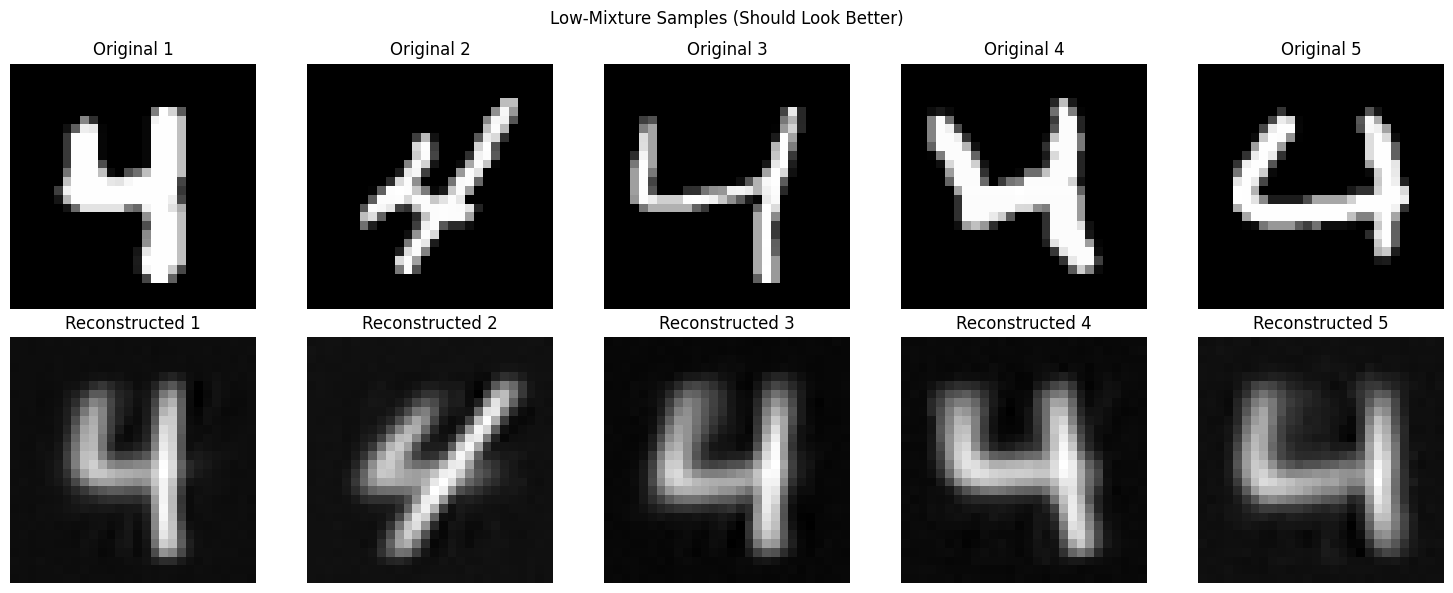

In [355]:
from scipy.stats import entropy

# Calculate how "mixed" each sample is
mix_strength = np.array([entropy(S_matrices[0][:, i]) for i in range(S_matrices[0].shape[1])])
mix_strength /= np.log(N_ARCHETYPES)  # normalize

# Show samples with low mixing (close to pure archetypes)
pure_samples = np.where(mix_strength < 0.2)[0]
print(f"Found {len(pure_samples)} relatively pure samples")
print("Indices of pure samples:", pure_samples[:10])

plot_reconstruction_flat(X_samples[pure_samples[:5]], 
                        X_rec[pure_samples[:5]],
                        title="Low-Mixture Samples (Should Look Better)")

np.save("X_rec_AANET.npy", X_rec)


### DAQUI PARA BAIXO É EXTRA STUFF FORM THE TUTORIAL

---

### Visualize latent space

In [309]:
archetypal_embedding = model.encode(torch.Tensor(data_digit))
vertices_embedding = model.get_n_simplex(n=3)
barycentric_archetypal_embedding = model.euclidean_to_barycentric(archetypal_embedding).detach().numpy()

<Axes: >

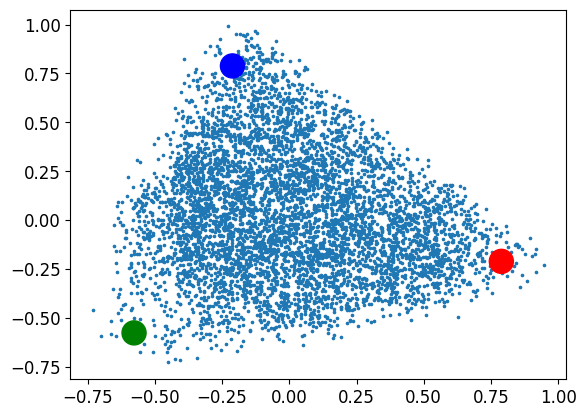

In [310]:
fig, ax = plt.subplots()
scprep.plot.scatter2d(archetypal_embedding.detach().numpy(), ax=ax)
scprep.plot.scatter2d(vertices_embedding.detach().numpy(), ax=ax, c=['red', 'blue', 'green'], s=300)

### Visualize average of 20 images nearest each archetype

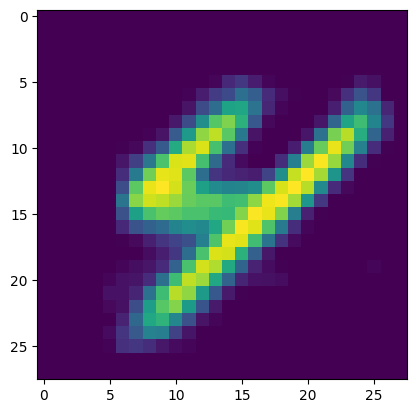

In [311]:
images_close_to_red_archetype_idx = np.argsort(barycentric_archetypal_embedding[:, 0])[::-1][:20]
images_close_to_red_archetype = data_digit[images_close_to_red_archetype_idx].reshape(20, 28, 28)
plt.imshow(images_close_to_red_archetype.mean(axis=0))

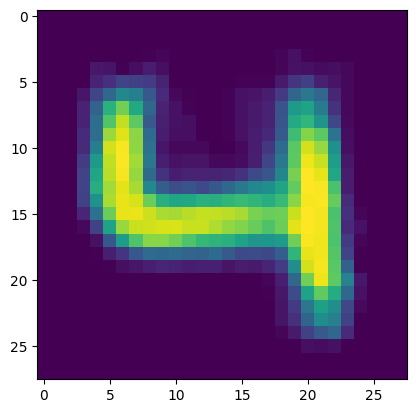

In [312]:
images_close_to_blue_archetype_idx = np.argsort(barycentric_archetypal_embedding[:, 1])[::-1][:20]
images_close_to_blue_archetype = data_digit[images_close_to_blue_archetype_idx].reshape(20, 28, 28)
plt.imshow(images_close_to_blue_archetype.mean(axis=0))

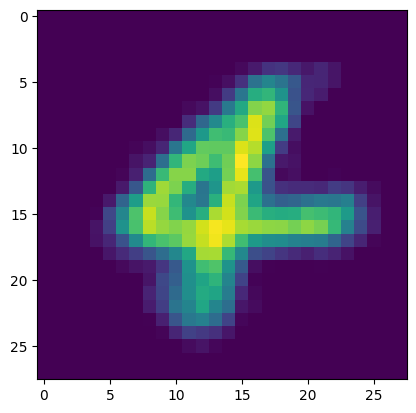

In [313]:
images_close_to_green_archetype_idx = np.argsort(barycentric_archetypal_embedding[:, 2])[::-1][:20]
images_close_to_green_archetype = data_digit[images_close_to_green_archetype_idx].reshape(20, 28, 28)
plt.imshow(images_close_to_green_archetype.mean(axis=0))